In [74]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import pylab as pl
from keras.constraints import maxnorm
from keras.optimizers import SGD
from scipy.misc import imread
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
K.set_image_dim_ordering('th')

seed = 128
np.random.seed(seed)

In [2]:
# data: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
data = pd.read_csv('fer2013/fer2013.csv', sep=',')

In [8]:
# Gathering data
train = data[data["Usage"] == 'Training']
test = data[data["Usage"] == 'PrivateTest']
val = data[data["Usage"] == 'PublicTest']
y_train = np.array(train['emotion'].apply(lambda x: np.array([x])))
y_test = np.array(test['emotion'].apply(lambda x: np.array([x])))
y_val = np.array(val['emotion'].apply(lambda x: np.array([x])))
X_train = np.array(list(map(lambda s : np.array(s.split(' '), dtype='float32').reshape(48, 48), 
                            list(train['pixels']))))
X_test = np.array(list(map(lambda s : np.array(s.split(' '), dtype='float32').reshape(48, 48), 
                            list(test['pixels']))))
X_val = np.array(list(map(lambda s : np.array(s.split(' '), dtype='float32').reshape(48, 48), 
                            list(val['pixels']))))

In [9]:
# Preparing data
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0
X_train = X_train.reshape(X_train.shape[0], 1, 48, 48)
X_test = X_test.reshape(X_test.shape[0], 1, 48, 48)
X_val = X_val.reshape(X_test.shape[0], 1, 48, 48)

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)
num_classes = y_test.shape[1]

In [17]:
# Model
model = Sequential()
model.add(Convolution2D(48, 3, 3, input_shape=(1, 48, 48), border_mode='same', activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Convolution2D(48, 3, 3, activation='relu', border_mode='same', W_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(96, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(96, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

epochs = 25
lrate = 0.009
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_17 (Convolution2D) (None, 48, 48, 48)    480         convolution2d_input_5[0][0]      
____________________________________________________________________________________________________
dropout_19 (Dropout)             (None, 48, 48, 48)    0           convolution2d_17[0][0]           
____________________________________________________________________________________________________
convolution2d_18 (Convolution2D) (None, 48, 48, 48)    20784       dropout_19[0][0]                 
____________________________________________________________________________________________________
maxpooling2d_9 (MaxPooling2D)    (None, 48, 24, 24)    0           convolution2d_18[0][0]           
___________________________________________________________________________________________

In [18]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), nb_epoch=epochs, batch_size=32)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 28709 samples, validate on 3589 samples
Epoch 1/25
28709/28709 [==============================] - 1925s - loss: 1.7781 - acc: 0.2703 - val_loss: 1.7210 - val_acc: 0.3037
Epoch 2/25
28709/28709 [==============================] - 1789s - loss: 1.6616 - acc: 0.3457 - val_loss: 1.6040 - val_acc: 0.3731
Epoch 3/25
28709/28709 [==============================] - 1851s - loss: 1.5740 - acc: 0.3877 - val_loss: 1.5287 - val_acc: 0.4037
Epoch 4/25
28709/28709 [==============================] - 1864s - loss: 1.5043 - acc: 0.4147 - val_loss: 1.4487 - val_acc: 0.4458
Epoch 5/25
28709/28709 [==============================] - 2023s - loss: 1.4382 - acc: 0.4482 - val_loss: 1.4102 - val_acc: 0.4508
Epoch 6/25
28709/28709 [==============================] - 1813s - loss: 1.3785 - acc: 0.4734 - val_loss: 1.3479 - val_acc: 0.4817
Epoch 7/25
28709/28709 [==============================] - 1990s - loss: 1.3254 - acc: 0.4925 - val_loss: 1.3213 - val_acc: 0.4896
Epoch 8/25
28709/28709 [=================

In [31]:
model.save("model.h5")

In [195]:
import numpy.ma as ma
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

# for convenience in showing pictures
def to2dim(imgs, rows, cols, border=1):
    imshape = imgs.shape[1:]
    grid = ma.masked_all((rows * imshape[0] + (rows - 1) * border,
                           cols * imshape[1] + (cols - 1) * border),
                          dtype=np.float32)
    h = imshape[0] + border
    w = imshape[1] + border
    
    for i in range(imgs.shape[0]):
        row = int(np.floor(i / cols))
        col = i % cols
        grid[row * h : row * h + imshape[0], col * w : col * w + imshape[1]] = imgs[i]
    return grid

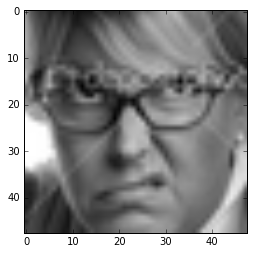

In [196]:
X = X_test[0:1]
plt.imshow(X[0][0], cmap='gray')

In [197]:
# functions converting model input to i-th layer output
inputs = [K.learning_phase()] + model.inputs
functions = [K.function(inputs, [layer.output]) for layer in model.layers]

def convout_f(n, X):
    return functions[n]([0] + [X])

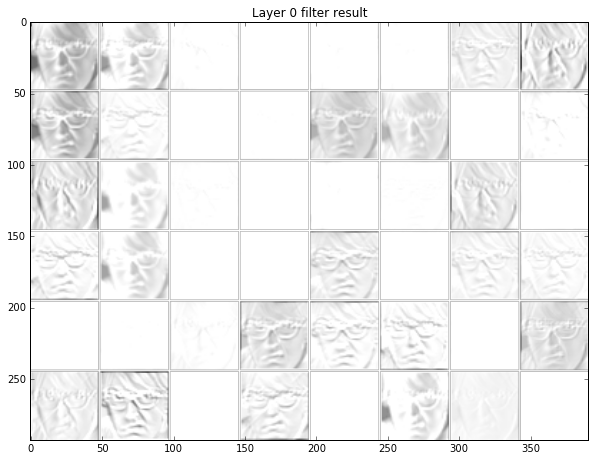

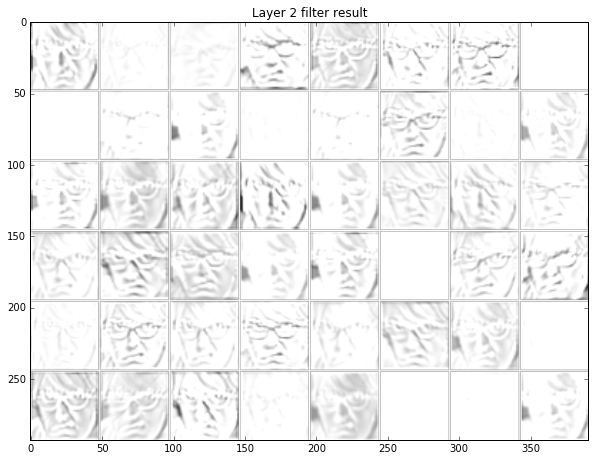

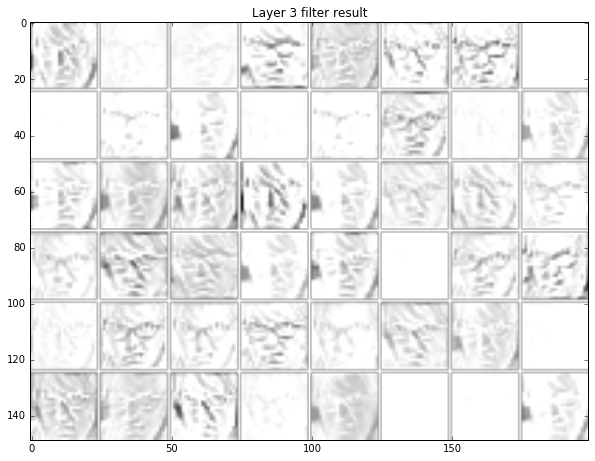

In [198]:
# Visualize convolution/pooling result
def print_C(layer_num, h=6, w=8, img = X, cmap=cm.binary):
    C = np.squeeze(convout_f(layer_num, img))
    pl.figure(figsize=(10, 10))
    pl.title("Layer " + str(layer_num) + " filter result")
    plt.imshow(to2dim(C, h, w), cmap=cmap)

print_C(0)
print_C(2)
print_C(3)

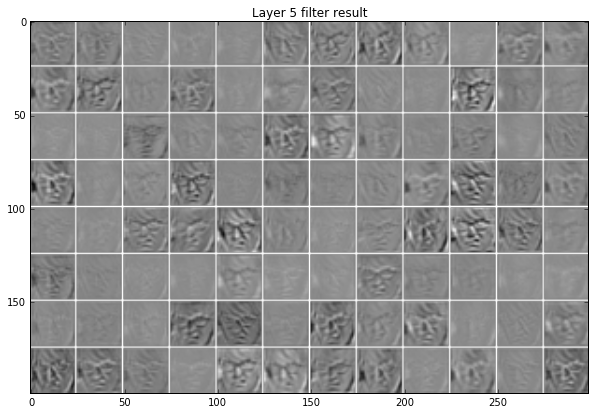

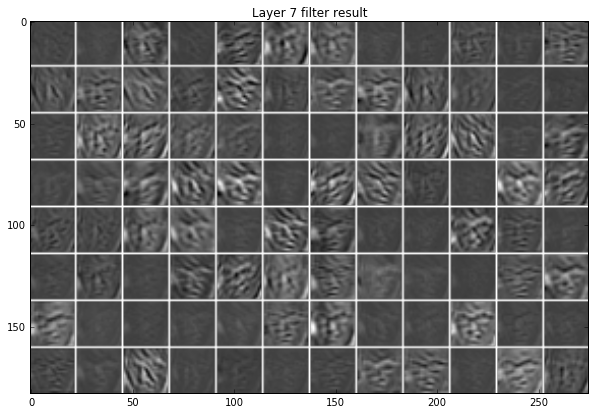

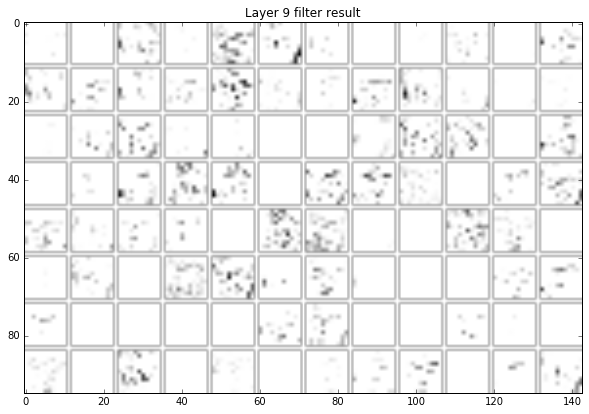

In [188]:
print_C(5, h=8, w=12)
print_C(7, h=8, w=12)
print_C(9, h=8, w=12)

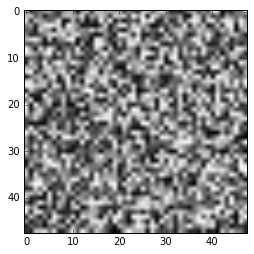

In [192]:
# trying filters on noisy image
img = np.random.random((1, 1, 48, 48)) * 40 + 128.
plt.imshow(img[0][0], cmap='gray')

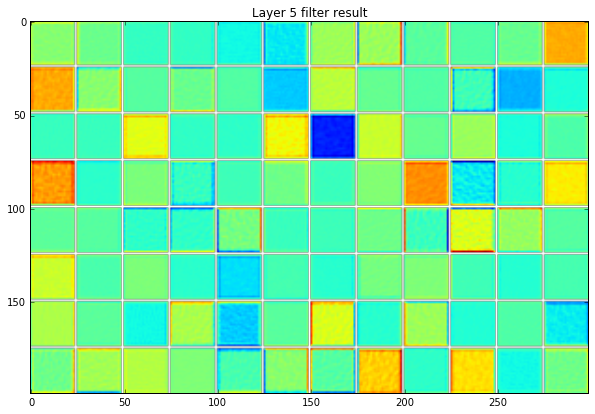

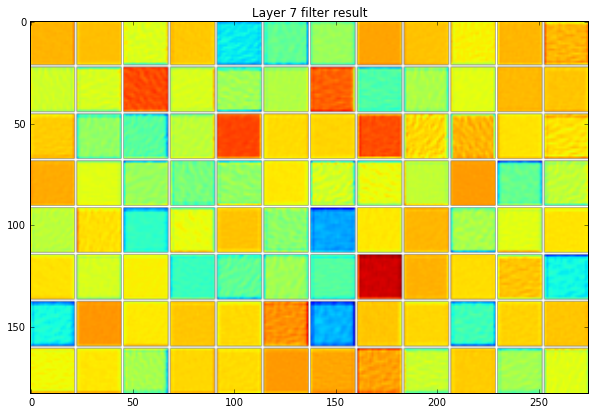

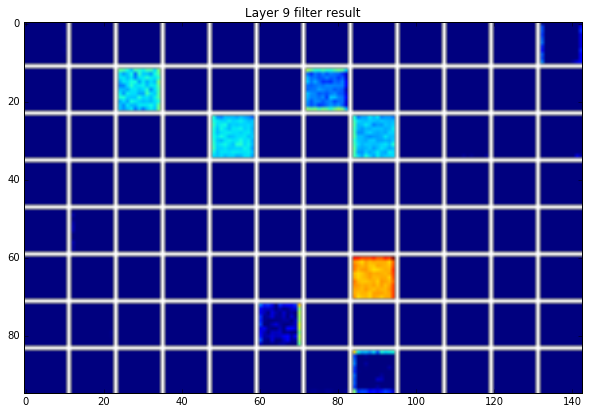

In [194]:
print_C(5, h=8, w=12, img=img, cmap=None)
print_C(7, h=8, w=12, img=img, cmap=None)
print_C(9, h=8, w=12, img=img, cmap=None)